# Algoritmo de Grover con 3 qubits

##### Primero importamos todas las librerías que vayamos a necesitar. Podemos encontrar tanto el código como la explicación teórica de su funcionamiento aquí en inglés:   

https://qiskit.org/textbook/ch-algorithms/grover.html#3.-Example:-3-Qubits-

In [6]:
#Importamos librerías de calculo numérico y visualización
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# importar Qiskit
from qiskit import IBMQ, BasicAer, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

from qiskit.visualization import plot_histogram

#### Definimos el oráculo que vaya a marcar los estados |110⟩ y |101⟩.

In [7]:
def phase_oracle(circuit, register):
    circuit.cz(qr[2],qr[0])
    circuit.cz(qr[2],qr[1])

#### Creamos la función que nos devolverá una puerta Z con múltiples controles y la funcion de inversión.

In [8]:
def n_controlled_Z(circuit, controls, target):
    """Implement a Z gate with multiple controls"""
    if (len(controls) > 2):
        raise ValueError('The controlled Z with more than 2 controls is not implemented')
    elif (len(controls) == 1):
        circuit.h(target)
        circuit.cx(controls[0], target)
        circuit.h(target)
    elif (len(controls) == 2):
        circuit.h(target)
        circuit.ccx(controls[0], controls[1], target)
        circuit.h(target)

In [9]:
def inversion_about_average(circuit, register, n, barriers):
    """Apply inversion about the average step of Grover's algorithm."""
    circuit.h(register)
    circuit.x(register)
    
    if barriers:
        circuit.barrier()
    
    n_controlled_Z(circuit, [register[j] for j in range(n-1)], register[n-1])
    
    if barriers:
        circuit.barrier()
    
    circuit.x(register)
    circuit.h(register)

#### Ahora simplemente juntamos las partes creando una superposición al comienzo del circuito con una puerta de Hadamard, que en qiskit es tan sencillo como emplear el método h del objeto quantumCircuit. Medimos al final con el método measure.

In [10]:
barriers = True

qr = QuantumRegister(3)
cr = ClassicalRegister(3)

groverCircuit = QuantumCircuit(qr,cr)
#Puerta de Hadamard
groverCircuit.h(qr)

if barriers:
    groverCircuit.barrier()

#Oráculo
phase_oracle(groverCircuit, qr)

if barriers:
    groverCircuit.barrier()

#Inversión
inversion_about_average(groverCircuit, qr, 3, barriers)

if barriers:
    groverCircuit.barrier()

#Medida final
groverCircuit.measure(qr,cr)

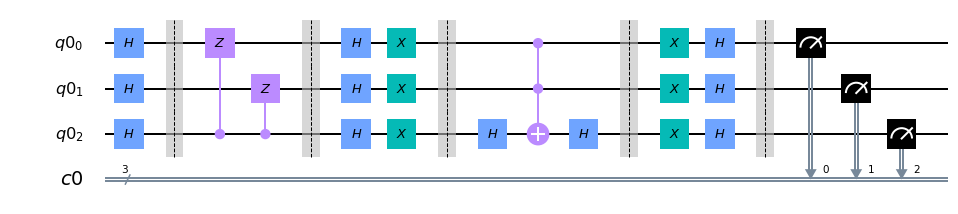

In [11]:
#Dibujamos y guardamos la figura
fig = groverCircuit.draw(output="mpl")
fig.savefig(fname = 'Grover3qubits', dpi = 300)
fig

#### Ahora que hemos montado el circuito podemos probar que funciona en un simulador. En este caso empleamos el simulador Qasm y medimos 1000 veces. Vemos que el algoritmo encuentra los dos elementos marcados inicialmente.

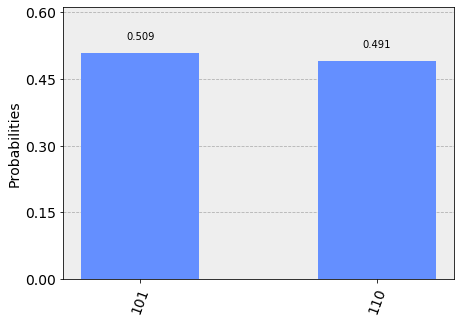

In [13]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 1000
results = execute(groverCircuit, backend=backend, shots=shots).result()
answer = results.get_counts()
fig1 = plot_histogram(answer)
fig1.savefig(fname = 'resultadossimulacion', dpi = 300)
fig1

#### Ahora vamos a pedir que un ordenador cuántico real realice la misma tarea, por lo que debemos cambiar el backend y cargar nuestras credenciales. Para hacer esta parte debemos regirstrarnos en IBM Q Experience y obtener las credenciales de nuestra cuenta. Tendremos un número limitado de tokens que se gastan al ejecutar tareas en los ordenadores cuánticos, pero se recargan diariamente.

In [25]:
provider = IBMQ.load_account()
device = least_busy(provider.backends(simulator=False))
print("Running on current least busy device: ", device)

Running on current least busy device:  ibmqx2


#### Este script automáticamente elige el ordenador con menos tareas en cola. Podemos cambiar el argumento 'shots' para elegir el número de veces que deseamos medir. Cuantas más veces midamos mejor resultado obtendremos pero más tiempo y mas tokens consumiremos.

In [30]:
from qiskit.tools.monitor import job_monitor
job = execute(groverCircuit, backend=device, shots=8000)
job_monitor(job, interval = 2)

Job Status: job has successfully run


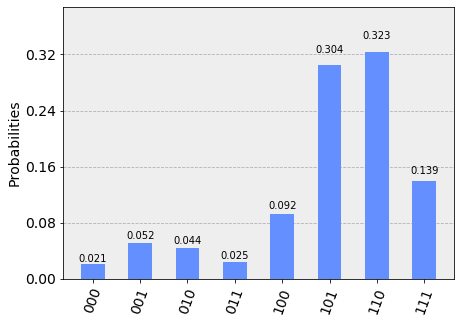

In [32]:
results = job.result()
answer = results.get_counts(groverCircuit)
fig2 = plot_histogram(answer)
fig2.savefig(fname = 'Resultados', dpi = 300)
fig2

#### Ahora representamos nuestros resultados, que como vemos distan de los resultados ideales del simulador debido a errores en el propio ordenador cuántico.